In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [28]:
PATH = 'data/imaterialist/'
arch = resnet34
sz=256

### checkout the content of data folder, should contains train/ valid/ test/ as well as csvs

In [29]:
#os.listdir(PATH)

['validation.json',
 'test',
 'valid_v2.csv',
 'trainvalid.csv',
 'train.json',
 'resnet50-128.h5',
 'train_v2.csv',
 'tmp',
 'models',
 'resnet34-256.h5',
 'script.py',
 '.ipynb_checkpoints',
 'valid',
 'train',
 'sample_submission_randomlabel.csv',
 'test.json']

(800, 801, 3)

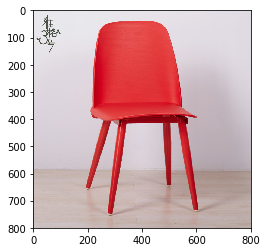

In [30]:
files = os.listdir(f'{PATH}train')[:5]
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img);
img.shape

In [55]:
import csv
import json
from shutil import copyfile
from random import *
    
def build_csv(file_name, cat):
    with open(f'{PATH}'+file_name, 'w') as csvfile:
        fieldnames = ['image_name','tags']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for file in os.listdir(f'{PATH}'+cat):
            try:
                Image.open(f'{PATH}'+cat+'/'+file).convert('RGB')
                writer.writerow({'image_name': file.split('.')[0], 'tags': file.split('.')[0].split('_')[1]})
            except Exception as ex:
                print (ex)
#run once            
#build_csv('train_v2.csv', 'train')
#build_csv('valid_v2.csv', 'valid')

img_dict = {}
json_data=open(f'{PATH}test.json').read()
data = json.loads(json_data)["images"]
for node in data:
    img_dict[node['image_id']] = str(node['url'])

tests = os.listdir(f'{PATH}test')

for file in tests:
    del img_dict[int(file.split('.')[0])]

print(len(img_dict))

# use random image if certain tests not exist
for k,v in img_dict.items():
    #DownloadImage (k,v)
    copyfile(f'{PATH}test/'+tests[random(0,len(tests)-1)], f'{PATH}test/'+str(k)+'.jpg')
    
print (len(os.listdir(f'{PATH}test')))

label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.3)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test')

0
12800


In [56]:
len(val_idxs)

38353

In [58]:
data = get_data(sz)

In [59]:
#download pre trained model from image net
learn = ConvLearner.pretrained(arch, data)

probe learning rate, as seen below, 10e-2 seems good learning rate to stick with 

In [10]:
#lrf=learn.lr_find()
#learn.sched.plot()

keep edge/ feature abstraction layers relative stable and focus on modify weights of classification layer

In [11]:
lr = 0.04
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.164124   0.911024   0.739262  
    1      1.027964   0.863273   0.749737                     
    2      0.788379   0.667964   0.804081                      



[0.66796446, 0.8040808823704719]

In [12]:
learn.save(f'{34}{sz}')
os.path.abspath(f'{34}{sz}')

'/home/cq/fastai/courses/dl1/34256'

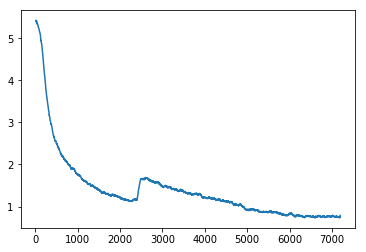

In [13]:
learn.sched.plot_loss()

In [14]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [15]:
accuracy_np(probs, y)

0.8110708419158866

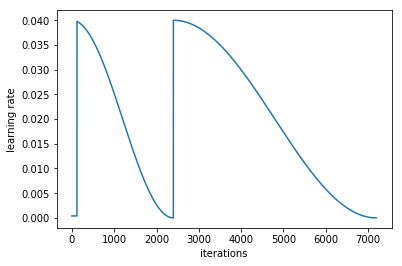

In [16]:
learn.sched.plot_lr()

In [17]:
#log_preds = learn.predict()
#log_preds.shape
lr = 0.01
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.714965   0.635242   0.813169  
    1      0.682762   0.63164    0.81578                       
    2      0.560789   0.595686   0.825968                      



[0.5956859, 0.8259681372841199]

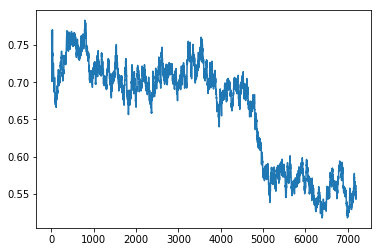

In [18]:
learn.sched.plot_loss()

In [61]:
learn.save(f'{34}{sz}-2')

In [62]:
log_preds,y = learn.TTA()

In [63]:
#print (data.test_ds.fnames[1], y[1])
print (len(data.test_ds.fnames))

12800


In [64]:
import csv

def export_test_result(files, y):
    with open(f'{PATH}submission.csv', 'w') as csvfile:
        fieldnames = ['id','predicted']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for idx, file in enumerate(files):
            try:
                writer.writerow({'id': file.split('/')[1].split('.')[0], 'predicted': y[idx]})
                del img_dict[file.split('/')[1].split('.')[0]]
            except Exception as ex:
                print (ex)
export_test_result(data.test_ds.fnames, y)

'5676'
'6530'
'7601'
'4129'
'9605'
'5524'
'2148'
'658'
'810'
'7059'
'2436'
'1113'
'7168'
'284'
'7225'
'7520'
'459'
'5743'
'9305'
'3686'
'12009'
'2075'
'8027'
'976'
'3913'
'10620'
'1670'
'2315'
'10591'
'12094'
'6429'
'10503'
'6828'
'2873'
'9518'
'5519'
'10473'
'3266'
'6253'
'12325'
'12246'
'11165'
'1069'
'1172'
'5850'
'12785'
'6916'
'17'
'7238'
'3745'
'1792'
'11546'
'6399'
'308'
'11678'
'7258'
'10192'
'7775'
'8045'
'9500'
'4390'
'4224'
'2158'
'5040'
'4548'
'4336'
'11657'
'8555'
'5670'
'11173'
'6708'
'3148'
'8026'
'8364'
'11671'
'949'
'2151'
'12209'
'2833'
'12756'
'10080'
'3040'
'11918'
'10135'
'165'
'23'
'1595'
'641'
'1266'
'6584'
'4585'
'10382'
'6990'
'6078'
'11708'
'7912'
'8803'
'11596'
'12336'
'10287'
'12076'
'2524'
'9261'
'11766'
'1899'
'9137'
'12017'
'962'
'3001'
'4959'
'6398'
'12764'
'8443'
'8066'
'3727'
'9515'
'1824'
'11502'
'4882'
'10550'
'7187'
'8700'
'2911'
'8357'
'10946'
'10426'
'1380'
'609'
'10602'
'6173'
'1279'
'9746'
'12695'
'8986'
'6806'
'7480'
'6845'
'10764'
'9889'
'3601

'3058'
'7047'
'1942'
'10123'
'10895'
'2521'
'7401'
'6344'
'11094'
'2608'
'2566'
'12099'
'4944'
'1548'
'3235'
'11111'
'1320'
'4702'
'1895'
'891'
'1606'
'11095'
'12032'
'996'
'5680'
'4045'
'11449'
'3800'
'6922'
'10580'
'2412'
'11473'
'9649'
'11002'
'2764'
'5412'
'9982'
'2303'
'10542'
'3944'
'5434'
'5421'
'8708'
'12450'
'10983'
'1607'
'8283'
'685'
'500'
'3959'
'11082'
'10914'
'9362'
'9134'
'7153'
'6480'
'5849'
'6770'
'11440'
'333'
'12458'
'2748'
'7955'
'829'
'6672'
'8724'
'1957'
'2800'
'6108'
'3673'
'3507'
'11738'
'1664'
'4326'
'887'
'371'
'756'
'11435'
'6282'
'298'
'446'
'11050'
'9094'
'11442'
'10789'
'7237'
'2536'
'4827'
'9576'
'3122'
'625'
'7582'
'2602'
'12385'
'1379'
'8265'
'5122'
'8569'
'6881'
'3257'
'3759'
'11516'
'1799'
'1378'
'9634'
'544'
'11001'
'12520'
'7697'
'6121'
'2365'
'11839'
'111'
'8382'
'1945'
'10859'
'89'
'3907'
'8326'
'4497'
'182'
'1593'
'3206'
'3337'
'9182'
'4842'
'9524'
'10122'
'9310'
'4355'
'1696'
'11760'
'10621'
'6252'
'12658'
'5698'
'8363'
'3868'
'11498'
'12697'
'6

'3537'
'9823'
'6513'
'8000'
'4502'
'8654'
'6132'
'3579'
'1797'
'5601'
'9291'
'9085'
'477'
'7953'
'2844'
'8958'
'9609'
'8498'
'1974'
'6661'
'9502'
'12702'
'6686'
'11000'
'5878'
'4694'
'10227'
'8064'
'7574'
'3893'
'1874'
'4870'
'3233'
'3949'
'4302'
'5869'
'8494'
'6491'
'6525'
'11355'
'12579'
'7202'
'6840'
'6039'
'1889'
'12016'
'12235'
'1250'
'743'
'5858'
'556'
'3055'
'7525'
'1245'
'2293'
'11223'
'8694'
'4323'
'7555'
'6137'
'5866'
'7950'
'7026'
'524'
'5137'
'1529'
'4416'
'7567'
'9691'
'9683'
'7231'
'12121'
'5442'
'8383'
'10866'
'3810'
'10496'
'7373'
'10152'
'1324'
'8608'
'7462'
'11427'
'7781'
'11552'
'10521'
'1561'
'5900'
'9251'
'9199'
'10470'
'8052'
'8765'
'3138'
'4481'
'8010'
'6707'
'3848'
'5026'
'3087'
'5424'
'9128'
'6780'
'3154'
'458'
'6704'
'8046'
'10171'
'7800'
'1170'
'10056'
'4292'
'3636'
'10162'
'5536'
'372'
'9614'
'9320'
'12095'
'4934'
'9276'
'3880'
'5498'
'11598'
'9755'
'2821'
'5543'
'6486'
'12699'
'4514'
'9286'
'6497'
'3430'
'7329'
'294'
'12234'
'7904'
'5440'
'1991'
'2116'
'905

In [ ]:
lr = 0.01
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.551474   0.592407   0.827518  
  2%|▏         | 59/2398 [00:36<24:13,  1.61it/s, loss=0.54]  